# Initialise

## Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from yellowbrick.regressor import residuals_plot
import statsmodels.api as sm
from scipy.stats import randint
from scipy.stats import uniform
from sklearn.model_selection import (
    train_test_split, 
    KFold,
    cross_val_score,
    GridSearchCV, RandomizedSearchCV
)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1500)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Define Filepaths

In [2]:
# Directory where I stored the datasets is one level above
INPUT_EMPLOYEES = f"../employee.csv"
INPUT_ALL_EMPLOYEES = f"../all_employees.csv"
INPUT_COMPANY_HIERARCHY = f"../company_hierarchy.csv"

## Define Helper Functions 

In [3]:
def read_csv(path):
    data = pd.read_csv(path)
    print(f"{path} has shape {data.shape}")
    return data

def early_diagnostics(df, y_column):
    print('==================== Null values ======================')
    print(df.isna().sum())
    print('==================== Df Info ======================')
    print(df.info())
    print('==================== Df Description ======================')
    print(df.describe())

def one_hot_encoding(df, dummy_vars, linear_regression=False):
    if linear_regression:
        drop_first=True
    else:
        drop_first=False
    data_ohe = pd.get_dummies(df[dummy_vars], drop_first=drop_first)
    df.drop(columns=dummy_vars, inplace=True)
    df = pd.concat([df, data_ohe], axis=1)
    print(f'Data has shape {df.shape} after one-hot encoding')
    return df

## Import Data Files

In [4]:
employees = read_csv(INPUT_EMPLOYEES)
all_employees = read_csv(INPUT_ALL_EMPLOYEES)
company_hierarchy = read_csv(INPUT_COMPANY_HIERARCHY)

../employee.csv has shape (10000, 6)
../all_employees.csv has shape (10000, 9)
../company_hierarchy.csv has shape (10000, 3)


# EDA

## High Level Observations

- Double checking to see what is the difference between the employee table and all_employee table.
- Conclusion is that the employee table is confirmed to be a subset of the all_employee table.
- Only difference is that the all_employee table's salary column is in thousands, while the employee table's salary column is not.
- Each row in all 3 data sets also correspond to one unique employee, no duplicates found.
- There are also no null values.
- On a high level perspective, the data description also shows no un-natural values.
- Male to female ratio is approximately 2:1.
- The company is relatively bottom-heavy, with a lot more ICs than managerial position levels. 
- Salary is not symmetrically distributed, and has a left skew.
- Those with signing bonus typically earn more than those without.
- Males typically earn more than females.
- HR department earns significaly less than the engineering, sales, and marketing department. 

In [5]:
test1 = all_employees[employees.columns].copy()
test1['salary'] = test1['salary']*1000
test2 = employees.copy()

print(f"test1 shape: {test1.shape}")
print(f"test2 shape: {test2.shape}")

test1 shape: (10000, 6)
test2 shape: (10000, 6)


In [6]:
test = test1.append(test2, sort=False)
test = test.drop_duplicates(
    ['employee_id', 'signing_bonus', 'salary', 'degree_level', 'sex', 'yrs_experience'], 
    keep=False
)

print(f"test shape: {test.shape}")

test shape: (0, 6)


In [7]:
print('Each row correspond to one unique employee?')
print(f"employees table: {employees['employee_id'].unique().shape[0] == employees.shape[0]}")
print(f"all_employees table: {all_employees['employee_id'].unique().shape[0] == all_employees.shape[0]}")
print(f"company_hierarchy table: {company_hierarchy['employee_id'].unique().shape[0] == company_hierarchy.shape[0]}")      

Each row correspond to one unique employee?
employees table: True
all_employees table: True
company_hierarchy table: True


In [8]:
early_diagnostics(all_employees, 'salary')

==================== Null values ======================
employee_id       0
signing_bonus     0
salary            0
degree_level      0
sex               0
yrs_experience    0
boss_id           0
dept              0
level             0
dtype: int64
==================== Df Info ======================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   employee_id     10000 non-null  int64 
 1   signing_bonus   10000 non-null  int64 
 2   salary          10000 non-null  int64 
 3   degree_level    10000 non-null  object
 4   sex             10000 non-null  object
 5   yrs_experience  10000 non-null  int64 
 6   boss_id         10000 non-null  int64 
 7   dept            10000 non-null  object
 8   level           10000 non-null  object
dtypes: int64(5), object(4)
memory usage: 703.2+ KB
None
==================== Df Description ===============

## Countplot of Categorical Variables

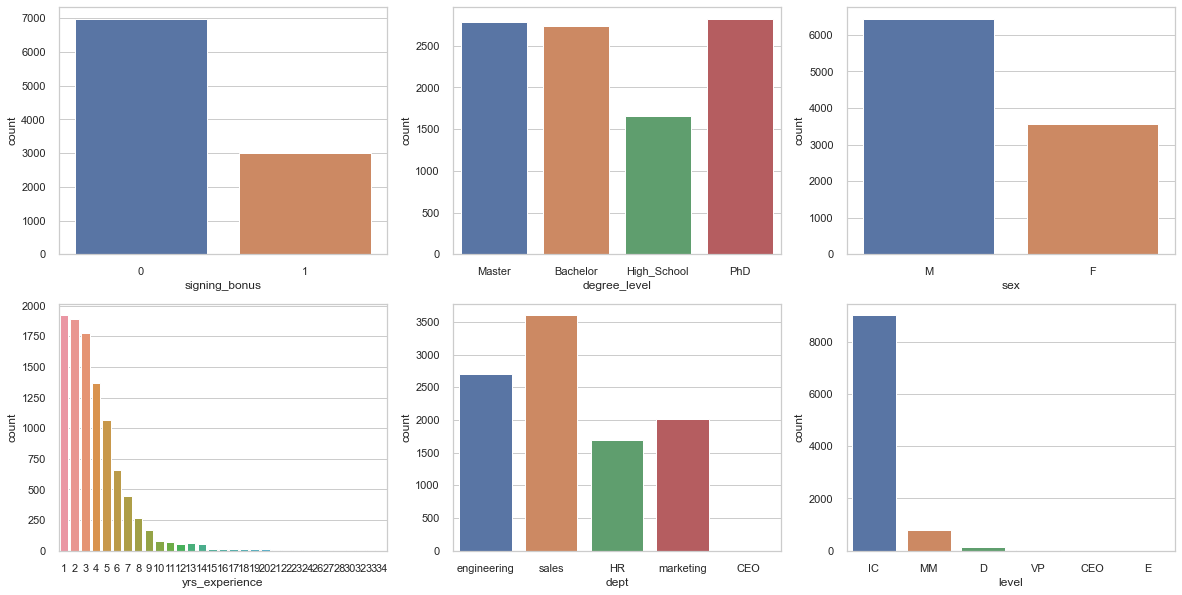

In [63]:
fig, axes = plt.subplots(2,3)
plt.rcParams['figure.figsize'] = (20, 10)
sns.set(style="whitegrid")

ax_signing_bonus = sns.countplot(x="signing_bonus", data=all_employees, ax=axes[0,0])
ax_degree_level = sns.countplot(x="degree_level", data=all_employees, ax=axes[0,1])
ax_sex = sns.countplot(x="sex", data=all_employees, ax=axes[0,2])
ax_yts_experience = sns.countplot(x="yrs_experience", data=all_employees, ax=axes[1,0])
ax_dept = sns.countplot(x="dept", data=all_employees, ax=axes[1,1])
ax_level = sns.countplot(x="level", data=all_employees, ax=axes[1,2])

## Distribution of Salary and log(Salary)

Text(0.5, 1.0, 'Log(Salary) Histogram')

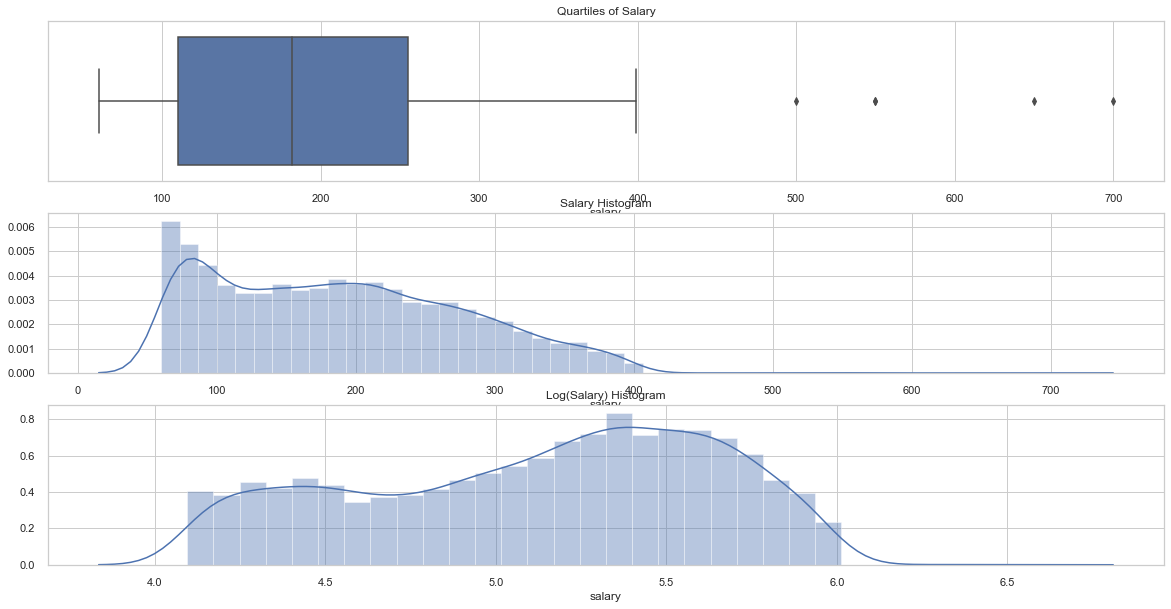

In [10]:
fig, axes = plt.subplots(3,1)
plt.rcParams['figure.figsize'] = (20, 15)
sns.set(style="whitegrid")

ax_salary = sns.boxplot(x=all_employees["salary"], orient='h', ax=axes[0])
ax_salary.set_title('Quartiles of Salary')

ax_salary_dist = sns.distplot(all_employees["salary"], ax=axes[1])
ax_salary_dist.set_title('Salary Histogram')

ax_log_salary_dist = sns.distplot((np.log(all_employees["salary"])), ax=axes[2])
ax_log_salary_dist.set_title('Log(Salary) Histogram')

## Boxplot of Salary vs Variables

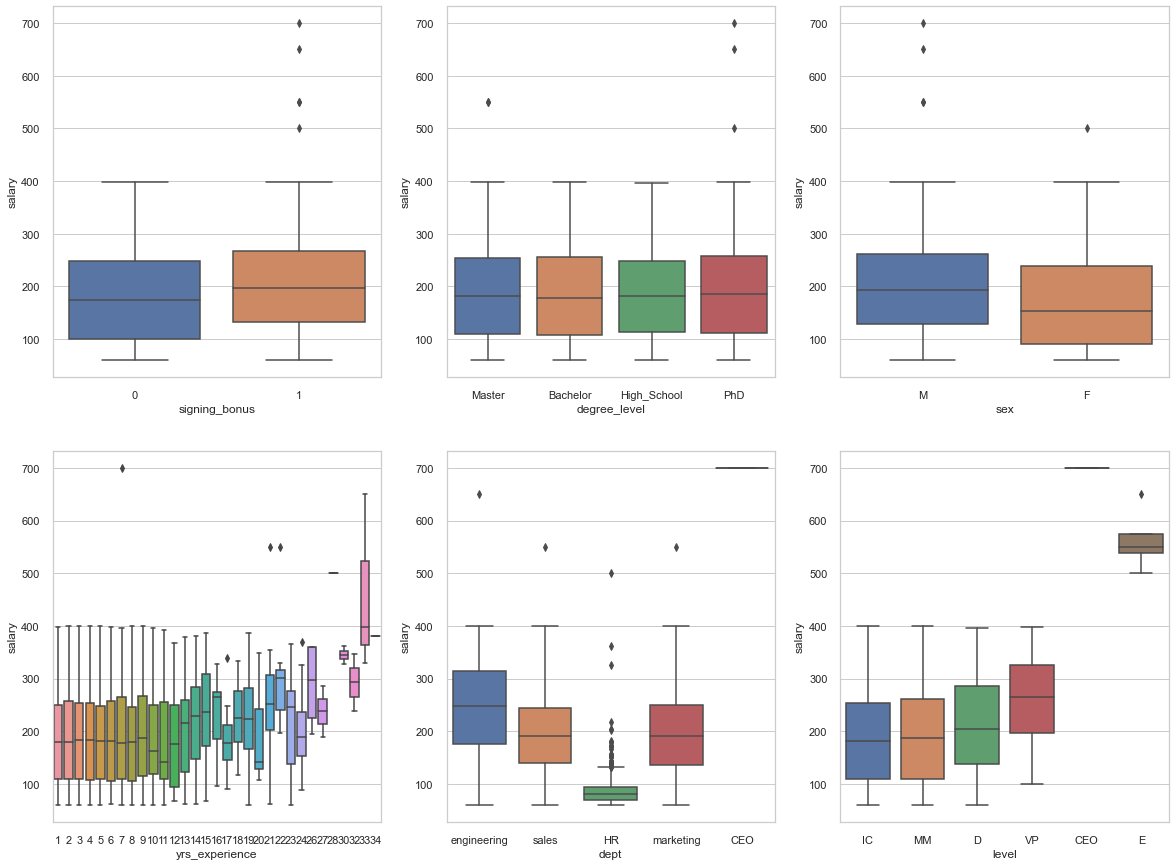

In [11]:
fig, axes = plt.subplots(2,3)
plt.rcParams['figure.figsize'] = (20, 15)
sns.set(style="whitegrid")

ax_signing_bonus = sns.boxplot(x="signing_bonus", y="salary", data=all_employees, ax=axes[0,0])
ax_degree_level = sns.boxplot(x="degree_level", y="salary", data=all_employees, ax=axes[0,1])
ax_sex = sns.boxplot(x="sex", y="salary", data=all_employees, ax=axes[0,2])
ax_yts_experience = sns.boxplot(x="yrs_experience", y="salary", data=all_employees, ax=axes[1,0])
ax_dept = sns.boxplot(x="dept", y="salary", data=all_employees, ax=axes[1,1])
ax_level = sns.boxplot(x="level", y="salary", data=all_employees, ax=axes[1,2])

## Boxplot of Salary vs Variables (Excl CEO and E)

In [12]:
check = all_employees['level'].isin(['IC', 'MM', 'D', 'VP'])
nonexcomm_employees = all_employees[check].reset_index(drop=True)

print(f"nonexcomm_employees shape: {nonexcomm_employees.shape}")

nonexcomm_employees shape: (9995, 9)


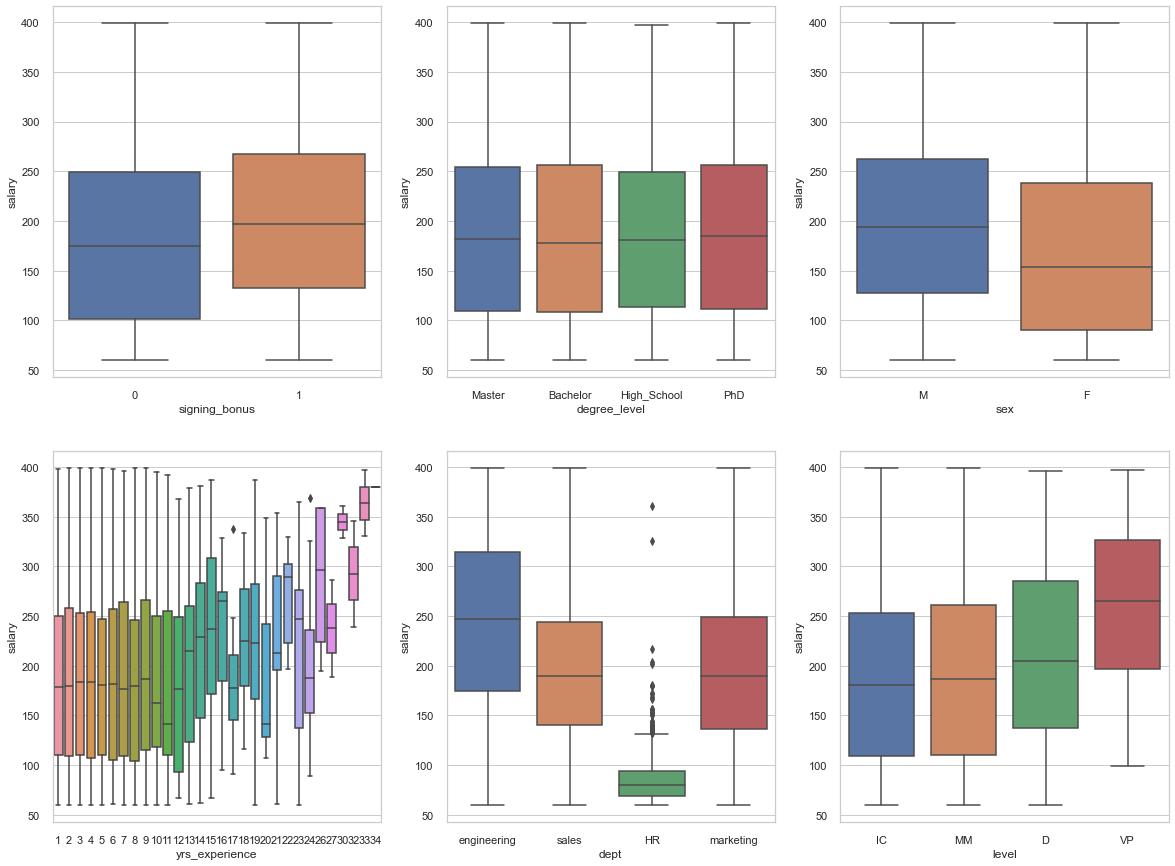

In [13]:
fig, axes = plt.subplots(2,3)
plt.rcParams['figure.figsize'] = (20, 15)
sns.set(style="whitegrid")

ax_signing_bonus = sns.boxplot(x="signing_bonus", y="salary", data=nonexcomm_employees, ax=axes[0,0])
ax_degree_level = sns.boxplot(x="degree_level", y="salary", data=nonexcomm_employees, ax=axes[0,1])
ax_sex = sns.boxplot(x="sex", y="salary", data=nonexcomm_employees, ax=axes[0,2])
ax_yts_experience = sns.boxplot(x="yrs_experience", y="salary", data=nonexcomm_employees, ax=axes[1,0])
ax_dept = sns.boxplot(x="dept", y="salary", data=nonexcomm_employees, ax=axes[1,1])
ax_level = sns.boxplot(x="level", y="salary", data=nonexcomm_employees, ax=axes[1,2])

# Assignment Body

Company ABC, a Deloitte member firm, has always been a champion of diversity and inclusion in the workplace. However, there has been some talking about the lack of diversity in Company ABC in recent days. The Talent Leader is very concerned about that and has tasked you to analyze its internal data of employees to understand whether the company has been treating its employees fairly.

## Question 1
In company ABC, there are 6 levels of employee hierarchy described below. Can you identify the corresponding level of each employee and hence the numbers of employees in each level?
    - Individual contributors (IC) – don’t manage anyone
    - Middle managers (MM) – the direct bosses of IC
    - Directors (D) – the direct bosses of MM
    - VP – the direct bosses of D
    - Executives (E) – the direct bosses of VP
    - CEO – the direct boss of E

In [14]:
print(f"The number of employees in each level are:")
print(all_employees['level'].value_counts())

The number of employees in each level are:
IC     9000
MM      800
D       160
VP       35
E         4
CEO       1
Name: level, dtype: int64


## Question 2
How many people does each employee manage? You should have a table with employee IDs and the number of people being managed. You may consider that if Peter directly manages 2 people and these 2 people manage 5 people each, then we can conclude that Peter actually manages 12 people.

Methodology:
1. Obtain list of unique employee ids of levels that has the authority to manage employees (basically all levels except 'IC'). 
    - Expect to have 1000 unique ids, as implied from Qn 1 that there are 1000 employees that are non 'IC'. 
    - Out of these 1000 employees, only 999 would have a manager, as a CEO would not have a manager.
    - The boss_id = -1 would probably indicate the total employees under the company.
2. Initialise two dictionaries with the boss_id as the key, and a list of employee_id as the value:
    - manager_emp_map will only have the employees who report directly to them (no sub-reporting levels) as the values.
    - manager_emp_count_map will have the same values as manager_emp_map in this step.
    - Store all direct-reporting employees as a list for each boss_id.
3. In manager_emp_count_map:
    - For each of the boss_id (key), we will look at each of the employee_id under this boss_id. 
    - If the employee_id can be found in manager_emp_map, it means that there are sub-reporting levels under this employee_id, and we will add these sub-reporting employee_id to the end of the list.
    - This would continue recursively until it reaches the end of the list.
    - The final output is that for each of the boss_id (key), we will have a list of all direct reporting and sub-reporting levels. 
4. Compute the length of the list under each boss_id in manager_emp_count_map, this would be the total number of people being managed by the boss_id. 
5. Convert the final dict into a pandas Dataframe.
6. __Final dataset to answer the question is manager_emp_count__

In [15]:
# Step 1
bosses = all_employees['boss_id'].unique()

# Step 2
manager_emp_map = {}
manager_emp_count_map = {}

for boss in bosses:
    
    check = all_employees['boss_id'] == boss
    temp = all_employees[check]
    
    manager_emp_map[boss] = list(temp['employee_id'])
    manager_emp_count_map[boss] = list(temp['employee_id'])

In [16]:
#Step 3
for key in manager_emp_count_map:
    
    for value in manager_emp_count_map[key]:
        
        try:
            manager_emp_count_map[key] += manager_emp_map[value]
        except KeyError:
            continue

In [17]:
# Step 4
for key in manager_emp_count_map:
    manager_emp_count_map[key] = len(manager_emp_count_map[key])

In [18]:
# Step 5
manager_emp_count = pd.DataFrame(
    manager_emp_count_map.items(), 
    columns=['employee_id', 'number_of_managed']
)\
.sort_values(['number_of_managed'], ascending=False)\
.reset_index(drop=True)

print(f"manager_emp_count shape: {manager_emp_count.shape}")

manager_emp_count shape: (1000, 2)


## Question 3
Build a model that can predict the salary of each employee.

Methodology:
1. First, consider several sets of data:
    - Set 1: Consists of the entire data set. 
    - Set 2: Consists of the entire data set, but taking log(salary) instead of salary. Reason for this is because salary is left-skewed, so in an attempt to pull in the high numbers, use log-transformation. 
    - Set 3: Consists of partial data set, removed CEO and D levels. Reason for this is because CEO and D are extreme values, if included, the models might place additional weight on these values. We can use this set to compare with the performance on Set 1.
2. For each set, run 4 models:
    - Linear Regression (baseline model)
    - RF with default settings
    - RF with Hyperparameter Tuning
    - LightGBM with Hyperparameter Tuning
3. Compare performance of all models, across all sets:
    - Metrics of evaluation used here is Root Mean Squared Error. Reason for using RMSE is to account for the the larger values from the higher salary earners, which in this case means that large errors are particularly undesirable. 
4. Evaluation
    - The RMSE is lowest for the Linear Regression Model in Set 3.
    - The Multiple Linear Regression Model also performs better than other models across all Sets.
    - Therefore, the selected model that can be used to predict the salary of each employee would be a Multiple Linear Regression Model.

In [33]:
def split_dataset(df, x_vars, y_var):
    """
    Randomise first before splitting
    """
    df = df.sample(frac=1, random_state=42)
    X = df[x_vars]
    y = df[y_var]
    print(f'Target variable has shape {y.shape}')
    print(f'Input variables have shape {X.shape}')
    return X, y

def one_hot_encoding(df, dummy_vars, linear_regression=False):
    if linear_regression:
        drop_first=True
    else:
        drop_first=False
    data_ohe = pd.get_dummies(df[dummy_vars], drop_first=drop_first)
    df.drop(columns=dummy_vars, inplace=True)
    df = pd.concat([df, data_ohe], axis=1)
    print(f'Data has shape {df.shape} after one-hot encoding')
    return df

def train_test_data(X, y, test_size):
    """
    We first we split the data using the standard function provided by sklearn
    Then we will turn all  the values into arrays to input into the regression models
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
#     X_train = X_train.values
#     X_test = X_test.values
#     y_train = y_train.values
#     y_test = y_test.values
    print(f'X_train has shape {X_train.shape}')
    print(f'X_test has shape {X_test.shape}')
    print(f'y_train has shape {y_train.shape}')
    print(f'y_test has shape {y_test.shape}')
    return X_train, X_test, y_train, y_test

def model_performance_mae(model, X_train, X_test, y_train, y_test, transform='None'):
    if transform == 'log':
        # these outputs will be in log terms
        y_train_pred = np.exp(model.predict(X_train))
        y_test_pred = np.exp(model.predict(X_test))
    elif transform == 'None':
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
    print(model)
    print('=======================================================')
    print(f'MAE on training data = {mean_absolute_error(y_train_pred, y_train)}')
    print(f'MAE on test data = {mean_absolute_error(y_test_pred, y_test)}')
    
def model_performance_rmse(model, X_train, X_test, y_train, y_test, transform='None'):
    if transform == 'log':
        # these outputs will be in log terms
        y_train_pred = np.exp(model.predict(X_train))
        y_test_pred = np.exp(model.predict(X_test))
    elif transform == 'None':
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
    print(model)
    print('=======================================================')
    print(f'RMSE on training data = {mean_squared_error(y_train_pred, y_train, squared=False)}')
    print(f'RMSE on test data = {mean_squared_error(y_test_pred, y_test, squared=False)}')
    
def plot_feature_importance(model, features):
    plt.rcParams['figure.figsize'] = (15, 5)
    base = features.columns
    feature_imp = [(f, i) for f, i in zip(base, model.feature_importances_.tolist())]
    ind = np.argsort(model.feature_importances_)[::-1]
    sns.barplot(x = np.asarray(base)[ind], y = model.feature_importances_[ind]).set_title('Feature importance')
    plt.xticks(rotation=90)
    plt.show()

### Set 1: Full Original Dataset
1. Split into X and y data.
2. Perform one-hot encoding on categorical variables.
3. Split X and y into test and train data.

In [20]:
X, y = split_dataset(
    all_employees,
    ['signing_bonus', 'degree_level', 'sex', 'yrs_experience', 'dept', 'level'],
    ['salary']
)

Target variable has shape (10000, 1)
Input variables have shape (10000, 6)


In [21]:
# Drop one of the levels in each one-hot encoded variable to avoid Dummy Variable Trap for Linear Regression Model
X_linear_regression = X.copy()
X_linear_regression = one_hot_encoding(X_linear_regression, ['degree_level', 'sex', 'dept', 'level'], linear_regression=True)

# Keep all levels of each one-hot encoded variable to use in the tree-based models
X = one_hot_encoding(X, ['degree_level', 'sex', 'dept', 'level'])

Data has shape (10000, 15) after one-hot encoding
Data has shape (10000, 19) after one-hot encoding


In [22]:
X_lr_train, X_lr_test, y_lr_train, y_lr_test = train_test_data(X_linear_regression, y, test_size=0.2)

X_train has shape (8000, 15)
X_test has shape (2000, 15)
y_train has shape (8000, 1)
y_test has shape (2000, 1)


In [23]:
X_train, X_test, y_train, y_test = train_test_data(X, y, test_size=0.2)

X_train has shape (8000, 19)
X_test has shape (2000, 19)
y_train has shape (8000, 1)
y_test has shape (2000, 1)


#### Linear Regression (Baseline Model)

In [24]:
model_lr_1 = LinearRegression()

model_lr_1.fit(X_lr_train, y_lr_train)

LinearRegression()

In [25]:
# # To check the coefficients of the linear model + various statistics
# X_lr_train = sm.add_constant(X_lr_train)

# model_lr = sm.OLS(y_lr_train, X_lr_train)

# results = model_lr.fit()

# print(results.summary())

#### RF Default Hyperparameters

In [26]:
model_rf_1 = RandomForestRegressor(random_state=42)
cv = KFold(n_splits=5, random_state=42)

model_rf_1.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

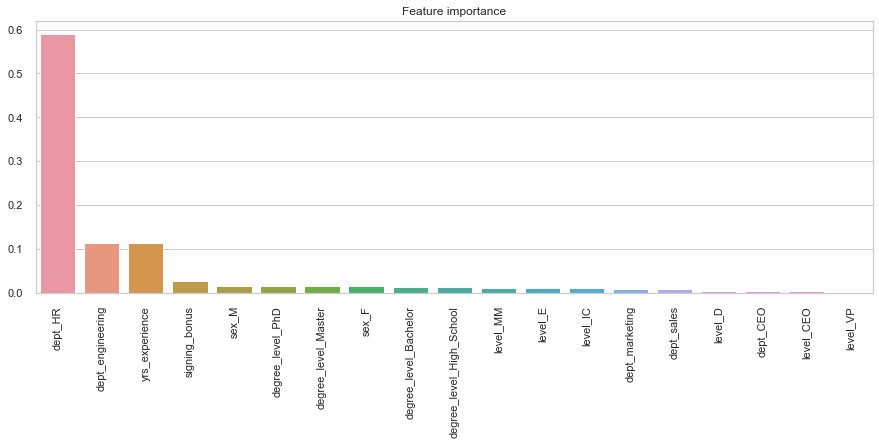

In [27]:
plot_feature_importance(model_rf_1, X)

#### RF RandomSearchCV

In [28]:
model_rf_grsr = RandomForestRegressor(random_state=42)
cv = KFold(n_splits=5, random_state=42)

params = {
    'bootstrap': [True, False],
    'max_depth': range(10,110,10),
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': range(1,20,1),
    'min_samples_split': range(1,50,5),
    'n_estimators': range(1,100,5)
}

grid_search_rf_grsr = RandomizedSearchCV(
    estimator=model_rf_grsr,
    param_distributions=params,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=42,
    n_iter=500,
)

grid_search_rf_grsr.fit(X_train, y_train)

best_model_rf_grsr_1 = grid_search_rf_grsr.best_estimator_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  5.3min finished


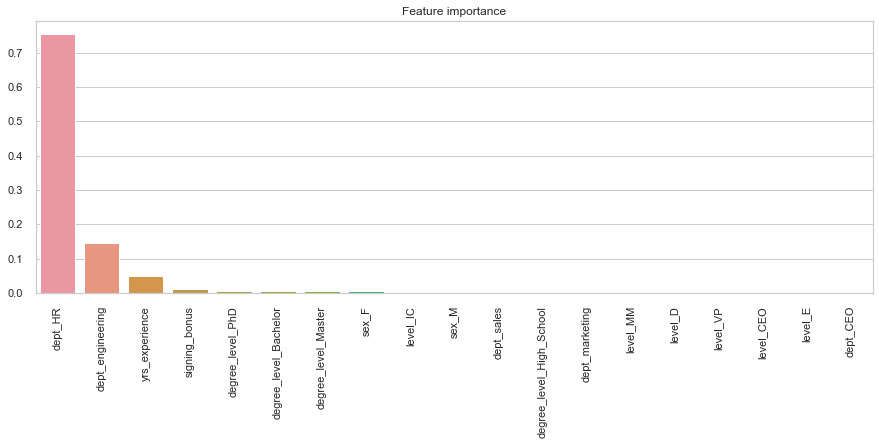

In [29]:
plot_feature_importance(best_model_rf_grsr_1, X)

#### LightGBM RandomSearchCV

In [30]:
model_xgb = LGBMRegressor()
cv = KFold(n_splits=5, random_state=42)

params = {
    'learning_rate': [0.1, 0.01, 0.05],
    'max_depth': range(2, 10, 1),
    'n_estimators': range(5, 50, 10),
    'num_leaves': randint(6, 50),
    'min_child_samples': randint(100, 500),
    'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    'subsample': uniform(loc=0.2, scale=0.8),
    'colsample_bytree': uniform(loc=0.4, scale=0.6),
    'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
    'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
}

grid_search_xgb = RandomizedSearchCV(
    estimator=model_xgb,
    param_distributions=params,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=42,
    n_iter=500,
)

grid_search_xgb.fit(X_train, y_train)

best_model_xgb_1 = grid_search_xgb.best_estimator_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 1340 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 2472 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:   36.7s finished


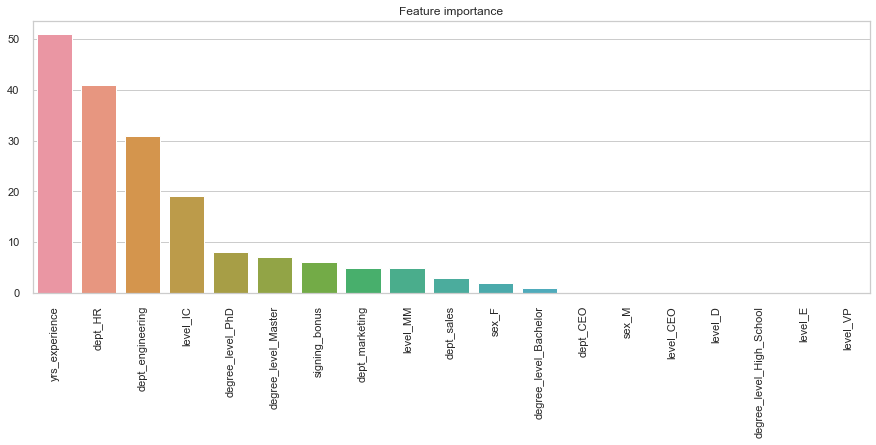

In [31]:
plot_feature_importance(best_model_xgb_1, X)

#### Set 1 Model Evaluation

In [34]:
print('Linear Regression:')
model_performance_rmse(model_lr_1, X_lr_train, X_lr_test, y_lr_train, y_lr_test)
print('')
print('RF Default Hyperparameters:')
model_performance_rmse(model_rf_1, X_train, X_test, y_train, y_test)
print('')
print('RF RandomSearchCV:')
model_performance_rmse(best_model_rf_grsr_1, X_train, X_test, y_train, y_test)
print('')
print('LightGBM RandomSearchCV:')
model_performance_rmse(best_model_xgb_1, X_train, X_test, y_train, y_test)

Linear Regression:
LinearRegression()
RMSE on training data = 71.64455642555038
RMSE on test data = 71.75099573832152

RF Default Hyperparameters:
RandomForestRegressor(random_state=42)
RMSE on training data = 67.03561318603474
RMSE on test data = 75.68013079345623

RF RandomSearchCV:
RandomForestRegressor(max_depth=10, min_samples_leaf=14, min_samples_split=21,
                      n_estimators=66, random_state=42)
RMSE on training data = 70.92630764547611
RMSE on test data = 72.45288227105826

LightGBM RandomSearchCV:
LGBMRegressor(colsample_bytree=0.8999902428838075, max_depth=3,
              min_child_samples=394, min_child_weight=1, n_estimators=45,
              num_leaves=47, reg_alpha=7, reg_lambda=20,
              subsample=0.4222576582253876)
RMSE on training data = 72.4430782410494
RMSE on test data = 71.89297751482279


### Set 2: Full Dataset, log Salary
1. Split into X and y data.
2. Split X and y into test and train data.
3. Perform one-hot encoding on categorical variables.
4. Transform salary by taking log(salary) to reduce effect of the extreme values for CEO and E levels.


In [35]:
X, y = split_dataset(
    all_employees,
    ['signing_bonus', 'degree_level', 'sex', 'yrs_experience', 'dept', 'level'],
    ['salary']
)

Target variable has shape (10000, 1)
Input variables have shape (10000, 6)


In [36]:
# Drop one of the levels in each one-hot encoded variable to avoid Dummy Variable Trap for Linear Regression Model
X_linear_regression = X.copy()
X_linear_regression = one_hot_encoding(X_linear_regression, ['degree_level', 'sex', 'dept', 'level'], linear_regression=True)

# Keep all levels of each one-hot encoded variable to use in the tree-based models
X = one_hot_encoding(X, ['degree_level', 'sex', 'dept', 'level'])

Data has shape (10000, 15) after one-hot encoding
Data has shape (10000, 19) after one-hot encoding


In [37]:
X_lr_train, X_lr_test, y_lr_train, y_lr_test = train_test_data(X_linear_regression, y, test_size=0.2)
y_lr_train_log = np.log(y_lr_train)
y_lr_test_log = np.log(y_lr_test)

X_train has shape (8000, 15)
X_test has shape (2000, 15)
y_train has shape (8000, 1)
y_test has shape (2000, 1)


In [38]:
X_train, X_test, y_train, y_test = train_test_data(X, y, test_size=0.2)
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

X_train has shape (8000, 19)
X_test has shape (2000, 19)
y_train has shape (8000, 1)
y_test has shape (2000, 1)


#### Linear Regression (Baseline Model)

In [39]:
model_lr_2 = LinearRegression()

model_lr_2.fit(X_lr_train, y_lr_train_log)

LinearRegression()

In [40]:
# # To check the coefficients of the linear model + various statistics
# X_lr_train = sm.add_constant(X_lr_train)

# model_lr = sm.OLS(y_lr_train_log, X_lr_train)

# results = model_lr.fit()

# print(results.summary())

#### RF Default Hyperparameters

In [41]:
model_rf_2 = RandomForestRegressor(random_state=42)

model_rf_2.fit(X_train, y_train_log)

RandomForestRegressor(random_state=42)

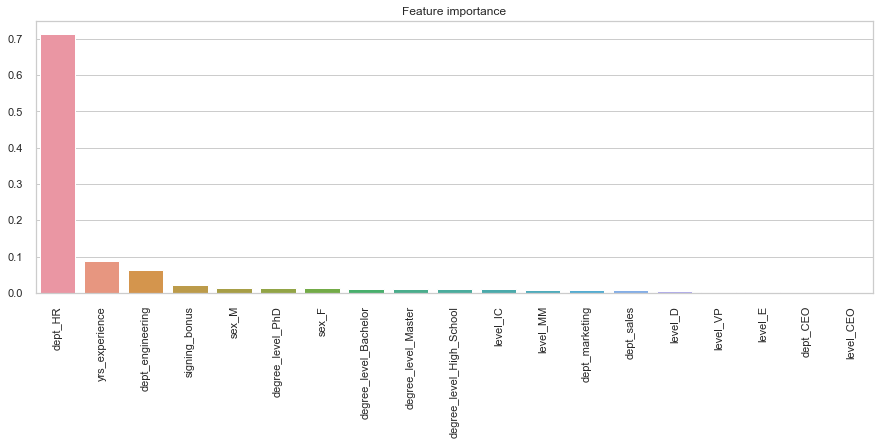

In [42]:
plot_feature_importance(model_rf_2, X)

#### RF RandomSearchCV

In [43]:
model_rf_grsr = RandomForestRegressor()
cv = KFold(n_splits=5, random_state=42)

params = {
    'bootstrap': [True, False],
    'max_depth': range(10, 110, 10),
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': range(1, 20, 1),
    'min_samples_split': range(1, 50, 5),
    'n_estimators': range(1, 100, 5)
}

random_search_rf_grsr = RandomizedSearchCV(
    estimator=model_rf_grsr,
    param_distributions=params,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=42,
    n_iter=500,
)

random_search_rf_grsr.fit(X_train, y_train_log)

best_model_rf_grsr_2 = random_search_rf_grsr.best_estimator_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  4.9min finished


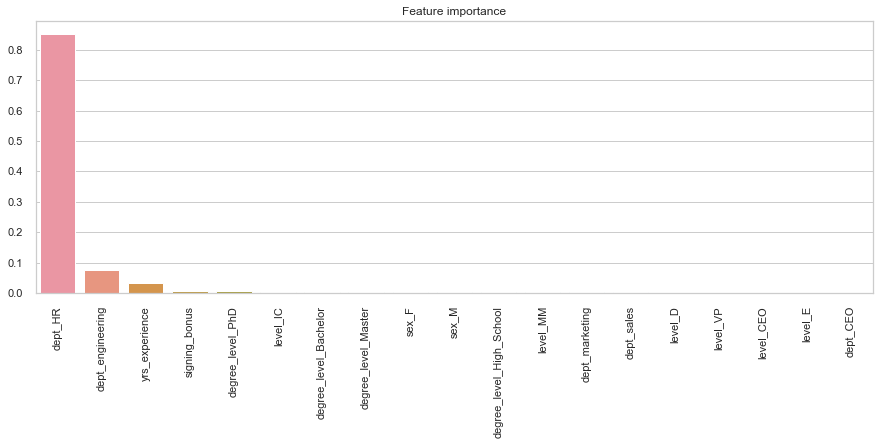

In [44]:
plot_feature_importance(best_model_rf_grsr_2, X)

#### LightGBM RandomSearchCV

In [45]:
model_xgb = LGBMRegressor()
cv = KFold(n_splits=5, random_state=42)

params = {
    'learning_rate': [0.1, 0.01, 0.05],
    'max_depth': range(2, 10, 1),
    'n_estimators': range(5, 50, 10),
    'num_leaves': randint(6, 50),
    'min_child_samples': randint(100, 500),
    'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    'subsample': uniform(loc=0.2, scale=0.8),
    'colsample_bytree': uniform(loc=0.4, scale=0.6),
    'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
    'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
}

random_search_xgb = RandomizedSearchCV(
    estimator=model_xgb,
    param_distributions=params,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=42,
    n_iter=500,
)

random_search_xgb.fit(X_train, y_train_log)

best_model_xgb_2 = random_search_xgb.best_estimator_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 576 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 1388 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:   38.6s finished


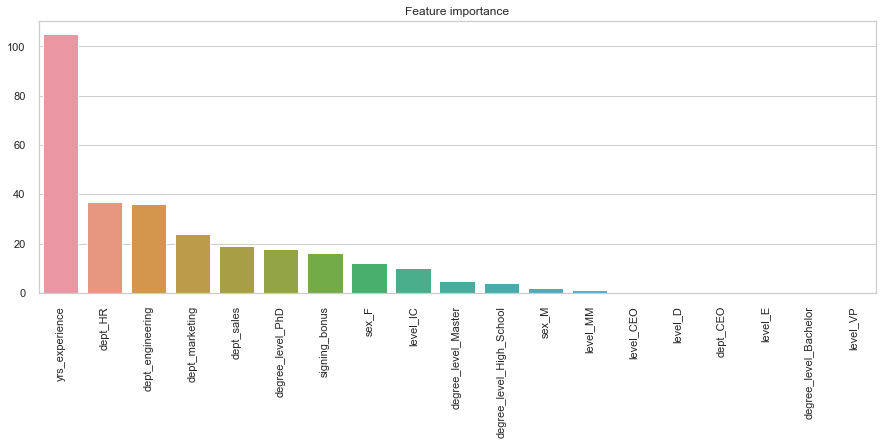

In [46]:
plot_feature_importance(best_model_xgb_2, X)

#### Set 2 Model Evaluation

In [47]:
print('Linear Regression:')
model_performance_rmse(model_lr_2, X_lr_train, X_lr_test, y_lr_train, y_lr_test, transform='log')
print('')
print('RF Default Hyperparameters:')
model_performance_rmse(model_rf_2, X_train, X_test, y_train, y_test, transform='log')
print('')
print('RF RandomSearchCV:')
model_performance_rmse(best_model_rf_grsr_2, X_train, X_test, y_train, y_test, transform='log')
print('')
print('LightGBM RandomSearchCV:')
model_performance_rmse(best_model_xgb_2, X_train, X_test, y_train, y_test, transform='log')

Linear Regression:
LinearRegression()
RMSE on training data = 73.26134090684779
RMSE on test data = 72.9691823109393

RF Default Hyperparameters:
RandomForestRegressor(random_state=42)
RMSE on training data = 68.5930478158324
RMSE on test data = 76.81758670782382

RF RandomSearchCV:
RandomForestRegressor(max_depth=10, min_samples_leaf=12, min_samples_split=41,
                      n_estimators=41)
RMSE on training data = 72.54317360602494
RMSE on test data = 73.51584376546357

LightGBM RandomSearchCV:
LGBMRegressor(colsample_bytree=0.8451377961752291, max_depth=6,
              min_child_samples=442, n_estimators=45, num_leaves=30,
              reg_alpha=1, reg_lambda=20, subsample=0.3002851806339085)
RMSE on training data = 73.92656954137482
RMSE on test data = 72.95971680020233


### Set 3: Remove CEO and D levels
1. Remove CEO and E (Excomm) levels to keep only the VP, D, MM, and IC levels.
2. Split into X and y data.
3. Split X and y into test and train data.
4. Perform one-hot encoding on categorical variables.

In [48]:
check = all_employees['level'].isin(['IC', 'MM', 'D', 'VP'])
nonexcomm_employees = all_employees[check].reset_index(drop=True)

print(f"nonexcomm_employees shape: {nonexcomm_employees.shape}")

nonexcomm_employees shape: (9995, 9)


In [49]:
X_nonexcomm, y_nonexcomm = split_dataset(
    nonexcomm_employees,
    ['signing_bonus', 'degree_level', 'sex', 'yrs_experience', 'dept', 'level'],
    ['salary']
)

Target variable has shape (9995, 1)
Input variables have shape (9995, 6)


In [50]:
# Drop one of the levels in each one-hot encoded variable to avoid Dummy Variable Trap for Linear Regression Model
X_nonexcomm_linear_regression = X_nonexcomm.copy()
X_nonexcomm_linear_regression = one_hot_encoding(X_nonexcomm_linear_regression, ['degree_level', 'sex', 'dept', 'level'], linear_regression=True)

# Keep all levels of each one-hot encoded variable to use in the tree-based models
X_nonexcomm = one_hot_encoding(X_nonexcomm, ['degree_level', 'sex', 'dept', 'level'])

Data has shape (9995, 12) after one-hot encoding
Data has shape (9995, 16) after one-hot encoding


In [51]:
X_nonexcomm_lr_train, \
X_nonexcomm_lr_test, \
y_nonexcomm_lr_train, \
y_nonexcomm_lr_test = train_test_data(X_nonexcomm_linear_regression, y_nonexcomm, test_size=0.2)

X_train has shape (7996, 12)
X_test has shape (1999, 12)
y_train has shape (7996, 1)
y_test has shape (1999, 1)


In [52]:
X_nonexcomm_train, \
X_nonexcomm_test, \
y_nonexcomm_train, \
y_nonexcomm_test = train_test_data(X_nonexcomm, y_nonexcomm, test_size=0.2)

X_train has shape (7996, 16)
X_test has shape (1999, 16)
y_train has shape (7996, 1)
y_test has shape (1999, 1)


#### Linear Regression (Baseline Model)

In [53]:
model_lr_3 = LinearRegression()

model_lr_3.fit(X_nonexcomm_lr_train, y_nonexcomm_lr_train)

LinearRegression()

In [54]:
# # To check the coefficients of the linear model + various statistics
# X_nonexcomm_lr_train = sm.add_constant(X_nonexcomm_lr_train)

# model_lr = sm.OLS(y_nonexcomm_lr_train, X_nonexcomm_lr_train)

# results = model_lr.fit()

# print(results.summary())

#### RF Default Hyperparameters

In [55]:
model_rf_3 = RandomForestRegressor(random_state=42)
cv = KFold(n_splits=5, random_state=42)

model_rf_3.fit(X_nonexcomm_train, y_nonexcomm_train)

RandomForestRegressor(random_state=42)

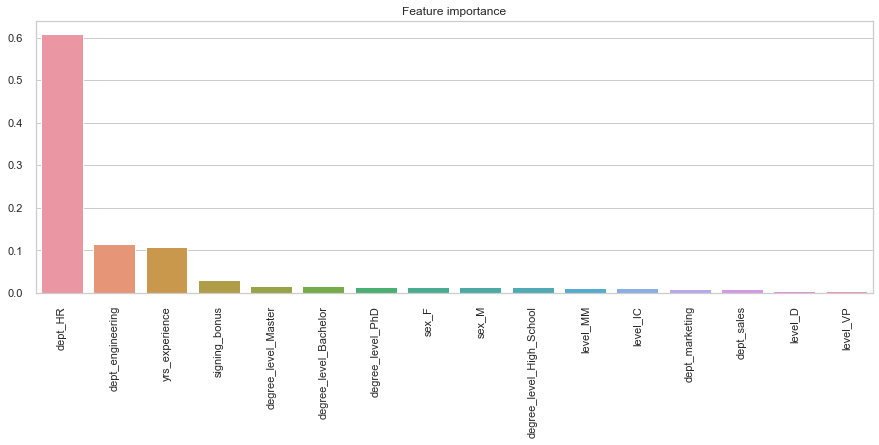

In [56]:
plot_feature_importance(model_rf_3, X_nonexcomm)

#### RF RandomSearchCV

In [57]:
model_rf_grsr = RandomForestRegressor(random_state=42)
cv = KFold(n_splits=5, random_state=42)

params = {
    'bootstrap': [True, False],
    'max_depth': range(10,110,10),
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': range(1,20,1),
    'min_samples_split': range(1,50,5),
    'n_estimators': range(1,100,5)
}

random_search_rf_grsr = RandomizedSearchCV(
    estimator=model_rf_grsr,
    param_distributions=params,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=42,
    n_iter=500,
)

random_search_rf_grsr.fit(X_nonexcomm_train, y_nonexcomm_train)

best_model_rf_grsr_3 = random_search_rf_grsr.best_estimator_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  4.5min finished


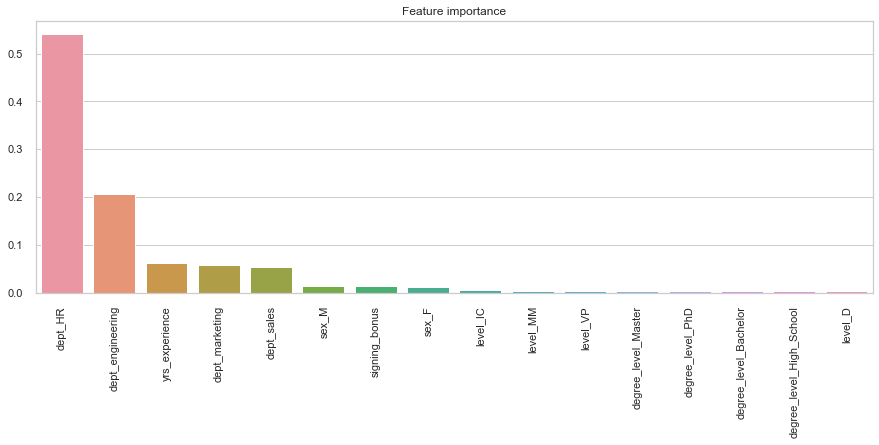

In [58]:
plot_feature_importance(best_model_rf_grsr_3, X_nonexcomm)

#### LightGBM GridSearchCV

In [59]:
model_xgb = LGBMRegressor()
cv = KFold(n_splits=5, random_state=42)

params = {
    'learning_rate': [0.1, 0.01, 0.05],
    'max_depth': range(2, 10, 1),
    'n_estimators': range(5, 50, 10),
    'num_leaves': randint(6, 50),
    'min_child_samples': randint(100, 500),
    'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    'subsample': uniform(loc=0.2, scale=0.8),
    'colsample_bytree': uniform(loc=0.4, scale=0.6),
    'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
    'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
}

random_search_xgb = RandomizedSearchCV(
    estimator=model_xgb,
    param_distributions=params,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=42,
    n_iter=500,
)

random_search_xgb.fit(X_nonexcomm_train, y_nonexcomm_train)

best_model_xgb_3 = random_search_xgb.best_estimator_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 576 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 1388 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:   37.1s finished


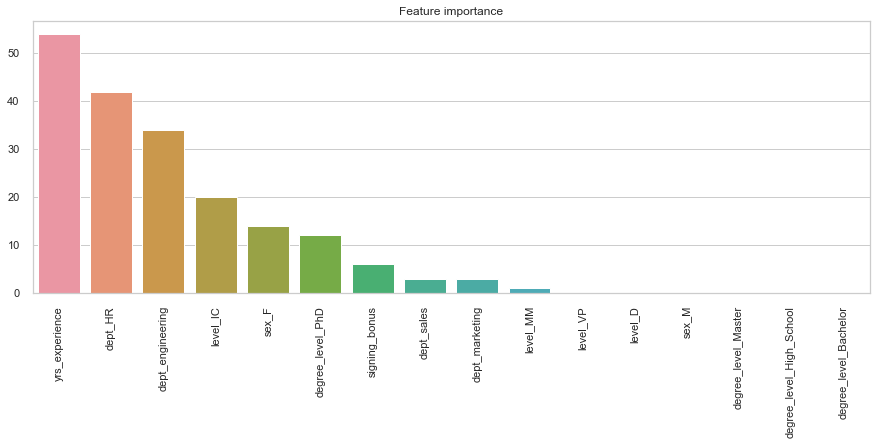

In [60]:
plot_feature_importance(best_model_xgb_3, X_nonexcomm)

#### Set 3 Model Evaluation

In [61]:
print('Linear Regression:')
model_performance_rmse(model_lr_3, X_nonexcomm_lr_train, X_nonexcomm_lr_test, y_nonexcomm_lr_train, y_nonexcomm_lr_test)
print('')
print('RF Default Hyperparameters:')
model_performance_rmse(model_rf_3, X_nonexcomm_train, X_nonexcomm_test, y_nonexcomm_train, y_nonexcomm_test)
print('')
print('RF RandomSearchCV:')
model_performance_rmse(best_model_rf_grsr_3, X_nonexcomm_train, X_nonexcomm_test, y_nonexcomm_train, y_nonexcomm_test)
print('')
print('LightGBM RandomSearchCV:')
model_performance_rmse(best_model_xgb_3, X_nonexcomm_train, X_nonexcomm_test, y_nonexcomm_train, y_nonexcomm_test)

Linear Regression:
LinearRegression()
RMSE on training data = 71.85847339187629
RMSE on test data = 70.97157291209197

RF Default Hyperparameters:
RandomForestRegressor(random_state=42)
RMSE on training data = 67.22172343140326
RMSE on test data = 73.86749961662012

RF RandomSearchCV:
RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=21,
                      n_estimators=51, random_state=42)
RMSE on training data = 70.06526180658089
RMSE on test data = 71.30427238931377

LightGBM RandomSearchCV:
LGBMRegressor(colsample_bytree=0.8999902428838075, max_depth=3,
              min_child_samples=394, min_child_weight=1, n_estimators=45,
              num_leaves=47, reg_alpha=7, reg_lambda=20,
              subsample=0.4222576582253876)
RMSE on training data = 71.9250633236087
RMSE on test data = 71.11593387852074


## Question 4
Describe the main factors affecting the employee salaries. Do you think the company has been treating its employees fairly? Do you see any bias? What are some next steps you would suggest to the Talent Leader?

__Describe the main factors affecting the employee salaries:__

Synthesing information from three sources: the EDA, the OLS summary of the regression models, and the feature importance of the tree-based regression models, the main factors affecting the employee salaries are:

1. Department - Based on the boxplots, the HR department is being paid significantly lower than other departments, while engineering is paid the most. The OLS coefficients are all significant at the 5% Significance Level, and the variable dept_HR and dept_engineering appears as one of the relatively more important features in all of the tree-based models.
2. Years of experience - Based on the boxplots, there is a general upward trend in salary as years of experience increases. The variable yrs_experience appears as one of the relatively more important features in all of the tree-based models.
3. Level - Based on the boxplots, there is a general upward trend in salary as level increases. There is a jump in overall salary when one's level increases from VP to E. Variables associated to Level also appear often as one of the relatively more important features in all of the tree-based models.
4. Sex - Based on the boxplots, in general males draw in a higher salary as compared to females, as seen by the interquartile range being higher for males than females. Variables associated to Sex also appear often as one of the relatively more important features in all of the tree-based models.
5. Signing Bonus - Based on the boxplots, those who have signing bonus draw in a higher salary as compared to those who do not, as seen by the interquartile range being higher for signing_bonus=1 compared to signing_bonus=0. Variables associated to Signing Bonus also appear often as one of the relatively more important features in all of the tree-based models.

__Do you think the company has been treating its employees fairly? Do you see any bias?__

I agree that in general, the company has been treating its employees fairly. In terms of salary, they do not distinguish between the degree level (seen from the same distribution of salary in the boxplots), and the company rewards those with experience and level (seen from the general upward trend of salary as years of experience/level increases).  

Notable observations:
1. Excomm (levels E and CEO) 
    - Despite the median Excomm salary being more than 3x that of the median IC salary, this would seem like a relatively reasonable amount as when compared to the average market practice where the CEO is paid 271 times more than a typical worker (Ref 1). 
2. Male vs Female salary 
    - From the boxplots, it can be seen that males are being paid higher than females. One possible reason for this is that there are more females in HR than male, where HR has a significantly lower salary than their counterparts in other departments.
3. HR salary - From the boxplots, it is clear to see that HR is paid significantly less than their counterparts in other departments. There could be non-quantitative biases for this, but based on the current data at hand two insights can be drawn:
    - Proportion of females in HR is a lot higher as compared to other departments (Ref 2). Females in general command a lower salary as seen from the salary distribution. 
    - Proportion of workers in HR who have a signing bonus is a lot lower compared to other departments (Ref 2). Signing_bonus=0 commands a lower salary as seen from the salary distribution. 


References:
- (1): https://www.cnbc.com/2018/01/22/heres-how-much-ceo-pay-has-increased-compared-to-yours-over-the-years.html
- (2): Code to check HR salary
``` python
c = all_employees.groupby(['dept', 'sex'])['employee_id'].count()
c / c.groupby(level=0).sum()
```
``` python
c = all_employees.groupby(['dept', 'signing_bonus'])['employee_id'].count()
c / c.groupby(level=0).sum()
```

__What are some next steps you would suggest to the Talent Leader?__

From the analysis, the one area of interest here would be the salary of the HR department. While having a lower comparative salary compared to other departments does not necessarily mean that there is systematic bias against the HR department, having a median salary that is more than two times less than the median salaries of other departments could warrant a study. One suggestion for the Talent Leader would be to review the kind of work that is done by the HR department, and to ensure that they are being compensated fairly. 

Should there really be a systematic bias in the HR salary, it is possible that a correction to the HR salary could lead to an improvement in the overall Male vs Female salary difference as well. This is because of the high proportion of females in the HR department. 